# Assignment Part A

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

try:
    import medmnist
except ImportError:
    !pip install medmnist
    import medmnist

from medmnist import PathMNIST
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


## Data Loading and Preprocessing

In [3]:
# Loading data using MedMNIST PathMNIST dataset
# Returns PyTorch DataLoaders for training, validation and test sets

def load_data(batch_size=32):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    train_dataset = PathMNIST(split='train', transform=data_transform, download=True)
    val_dataset = PathMNIST(split='val', transform=data_transform, download=True)
    test_dataset = PathMNIST(split='test', transform=data_transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


## Model Architecture

In [4]:
class SafeMaxPool2d(nn.Module):                  # Custom pooling class to avoid shape errors when input size is too small
    def __init__(self, kernel_size, stride):
        super(SafeMaxPool2d, self).__init__()
        self.original_kernel = kernel_size
        self.original_stride = stride

    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        kernel = min(self.original_kernel, h, w)
        stride = min(self.original_stride, h, w)
        if kernel < 2 or stride < 2 or h <= 2 or w <= 2:
            return x
        return F.max_pool2d(x, kernel_size=kernel, stride=stride)  # Check for minimum size

class CNN(nn.Module):
    def __init__(self, num_conv_layers=2, conv_kernel_size=5, pool_kernel_size=3,
                 pool_stride=2, activation_fn='relu', conv_dropout=0.5,
                 fc_hidden_units=256, fc_dropout=0.5):
        super(CNN, self).__init__()

        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'tanh':
            self.activation = nn.Tanh()
        elif activation_fn == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation_fn}")

        self.feature_layers = nn.ModuleList()
        in_channels = 3

        for i in range(num_conv_layers):
            self.feature_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=128,
                                                 kernel_size=conv_kernel_size,
                                                 padding=conv_kernel_size // 2))
            self.feature_layers.append(self.activation)
            if i > 0:
                self.feature_layers.append(nn.BatchNorm2d(128))
                self.feature_layers.append(nn.Dropout2d(conv_dropout))
            self.feature_layers.append(SafeMaxPool2d(pool_kernel_size, pool_stride))
            in_channels = 128

        self.feature_layers.append(nn.AdaptiveAvgPool2d((1, 1)))

        dummy_input = torch.randn(1, 3, 28, 28)
        with torch.no_grad():
            x = dummy_input
            for layer in self.feature_layers:
                x = layer(x)
            flattened_size = x.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, fc_hidden_units),
            self.activation,
            nn.Dropout(fc_dropout),
            nn.Linear(fc_hidden_units, 9)
        )

    def forward(self, x):
        for layer in self.feature_layers:
            x = layer(x)
        x = self.classifier(x)
        return x


## Training and Validation

In [5]:
# Function to train the model and validate it on val set each epoch
# Helps monitor overfitting and training behavior

# Training and validation function - helps us monitor both during epochs
def train_and_validate(model, train_loader, val_loader, optimizer_type='adam',
                       num_epochs=10, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Start training mode
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.squeeze().to(device)

            # Reset gradients before backprop
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Compute gradients
            loss.backward()
            # Update weights
            optimizer.step()

            running_loss += loss.item()
            # Get predicted class from logits
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        # Switch to evaluation mode (no gradients)
        model.eval()
        val_loss, correct, total = 0, 0, 0
        # Disable gradient tracking for validation or testing
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
            # Forward pass
                outputs = model(images)
            # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            # Get predicted class from logits
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1] * 100:.2f}%")


    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "final_val_acc": val_accs[-1],
        "final_val_loss": val_losses[-1]
    }


## Hyperparameter Experimentation

In [6]:
# Runs a controlled experiment for a specific hyperparameter

def run_experiment(param_name, param_values, fixed_params, batch_size=32, num_epochs=10):
    results = []

    for value in tqdm(param_values, desc=f"Testing {param_name}"):
        current_params = fixed_params.copy()
        current_params[param_name] = value

        # If tuning batch size or epochs
        current_batch_size = value if param_name == 'batch_size' else batch_size
        current_epochs = value if param_name == 'num_epochs' else num_epochs

        train_loader, val_loader, _ = load_data(batch_size=current_batch_size)

        model = CNN(
            num_conv_layers=current_params['num_conv_layers'],
            conv_kernel_size=current_params['conv_kernel_size'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            activation_fn=current_params['activation_fn'],
            conv_dropout=current_params['conv_dropout'],
            fc_hidden_units=current_params['fc_hidden_units'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)

        training_history = train_and_validate(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer_type=current_params['optimizer_type'],
            num_epochs=current_epochs
        )

        results.append({
            'param_value': value,
            'val_acc': training_history['final_val_acc'],
            'val_loss': training_history['final_val_loss'],
            'train_losses': training_history['train_losses'],
            'val_losses': training_history['val_losses'],
            'train_accs': training_history['train_accs'],
            'val_accs': training_history['val_accs']
        })

        del model
        torch.cuda.empty_cache()

    return results


In [7]:
# This function plots validation accuracy and loss against hyperparameter values
# Helps visualize which value worked best

def plot_experiment_results(results, param_name):
    values = [r['param_value'] for r in results]
    val_accs = [r['val_acc'] for r in results]
    val_losses = [r['val_loss'] for r in results]

    plt.figure()
    plt.plot(values, val_accs, marker='o')
    plt.title(f'Validation Accuracy vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(values, val_losses, marker='o')
    plt.title(f'Validation Loss vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Validation Loss')
    plt.grid(True)
    plt.show()

    return pd.DataFrame({
        param_name: values,
        'Validation Accuracy': val_accs,
        'Validation Loss': val_losses
    })


## Run All Experiments and Select Bests

In [8]:
# This function loops over all hyperparameters and tests different values for each
# After testing, it picks the best value (based on val accuracy) for each one

def run_all_experiments():
    baseline_params = {
        'num_conv_layers': 2,
        'conv_kernel_size': 5,
        'pool_kernel_size': 3,
        'pool_stride': 2,
        'activation_fn': 'relu',
        'conv_dropout': 0.5,
        'fc_hidden_units': 256,
        'fc_dropout': 0.5,
        'optimizer_type': 'adam',
        'batch_size': 32,
        'num_epochs': 10
    }

    experiments = {
        #'num_conv_layers': [1, 2, 3, 4, 5, 6],
        #'fc_hidden_units': [64, 128, 256, 512, 1024, 2048],
        #'pool_kernel_size': [2, 3, 4, 5, 6, 7],
        #'pool_stride': [1, 2, 3, 4, 5, 6],
        #'fc_dropout': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9],
        #'num_epochs': [5, 10, 20],
        'conv_kernel_size': [3, 5, 7, 9, 11, 13],
        'conv_dropout': [0.0, 0.2, 0.3, 0.5, 0.7, 0.9],
        'activation_fn': ['relu', 'tanh', 'sigmoid'],
        'batch_size': [16, 32, 64, 128, 256, 512],
        'optimizer_type': ['adam', 'sgd', 'rmsprop'],
    }


    all_results = {}
    best_values = {}

    for param, values in experiments.items():
        print(f"\n--- Running experiment for {param} ---")
        results = run_experiment(param, values, baseline_params)
        all_results[param] = results
        summary_table = plot_experiment_results(results, param)
        best_idx = summary_table['Validation Accuracy'].idxmax()
        best_value = summary_table.iloc[best_idx][param]
        best_values[param] = best_value
        print(f"Best {param}: {best_value}")

    return best_values, all_results


## Final Model Training and Test Evaluation

In [9]:
# Trains the final model using the best hyperparameters found from all experiments
# Then evaluates it on the test set (only once)

def train_final_model(best_params):
    train_loader, val_loader, test_loader = load_data(batch_size=int(best_params['batch_size']))
    model = CNN(
        num_conv_layers=int(best_params['num_conv_layers']),
        conv_kernel_size=int(best_params['conv_kernel_size']),
        pool_kernel_size=int(best_params['pool_kernel_size']),
        pool_stride=int(best_params['pool_stride']),
        activation_fn=(best_params['activation_fn']),
        conv_dropout=float(best_params['conv_dropout']),
        fc_hidden_units=int(best_params['fc_hidden_units']),
        fc_dropout=float(best_params['fc_dropout'])
    ).to(device)

    print("Training final model...")
    train_and_validate(model, train_loader, val_loader,
                       optimizer_type=best_params['optimizer_type'],
                       num_epochs=int(best_params['num_epochs']))

    print("Evaluating on test set...")
        # Switch to evaluation mode (no gradients)
    model.eval()
    y_true, y_pred = [], []
        # Disable gradient tracking for validation or testing
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return y_true, y_pred


##Execute All Experiments and Final Model Evaluation

Starting all experiments...

--- Running experiment for conv_kernel_size ---



Testing conv_kernel_size:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.7250, Train Acc: 73.53%, Val Loss: 0.4362, Val Acc: 83.87%
Epoch 2/10, Train Loss: 0.4932, Train Acc: 82.48%, Val Loss: 0.3173, Val Acc: 88.85%
Epoch 3/10, Train Loss: 0.4305, Train Acc: 84.78%, Val Loss: 0.2767, Val Acc: 89.95%
Epoch 4/10, Train Loss: 0.3825, Train Acc: 86.52%, Val Loss: 0.2731, Val Acc: 90.33%
Epoch 5/10, Train Loss: 0.3540, Train Acc: 87.77%, Val Loss: 0.2446, Val Acc: 91.25%
Epoch 6/10, Train Loss: 0.3330, Train Acc: 88.41%, Val Loss: 0.2075, Val Acc: 93.28%
Epoch 7/10, Train Loss: 0.3193, Train Acc: 89.05%, Val Loss: 0.2558, Val Acc: 91.22%
Epoch 8/10, Train Loss: 0.3012, Train Acc: 89.54%, Val Loss: 0.1831, Val Acc: 93.95%
Epoch 9/10, Train Loss: 0.2933, Train Acc: 89.86%, Val Loss: 0.1910, Val Acc: 93.44%



Testing conv_kernel_size:  17%|█▋        | 1/6 [04:50<24:13, 290.68s/it]

Epoch 10/10, Train Loss: 0.2818, Train Acc: 90.23%, Val Loss: 0.1628, Val Acc: 94.34%
Epoch 1/10, Train Loss: 0.8230, Train Acc: 70.00%, Val Loss: 0.5442, Val Acc: 80.64%
Epoch 2/10, Train Loss: 0.5706, Train Acc: 79.52%, Val Loss: 0.5086, Val Acc: 82.25%
Epoch 3/10, Train Loss: 0.4896, Train Acc: 82.50%, Val Loss: 0.5241, Val Acc: 82.12%
Epoch 4/10, Train Loss: 0.4452, Train Acc: 84.30%, Val Loss: 0.3753, Val Acc: 84.83%
Epoch 5/10, Train Loss: 0.4108, Train Acc: 85.54%, Val Loss: 0.3238, Val Acc: 88.91%
Epoch 6/10, Train Loss: 0.3866, Train Acc: 86.74%, Val Loss: 0.2684, Val Acc: 90.62%
Epoch 7/10, Train Loss: 0.3625, Train Acc: 87.32%, Val Loss: 0.2902, Val Acc: 89.51%
Epoch 8/10, Train Loss: 0.3431, Train Acc: 88.07%, Val Loss: 0.2664, Val Acc: 90.93%
Epoch 9/10, Train Loss: 0.3270, Train Acc: 88.67%, Val Loss: 0.2256, Val Acc: 92.21%



Testing conv_kernel_size:  33%|███▎      | 2/6 [09:36<19:10, 287.70s/it]

Epoch 10/10, Train Loss: 0.3221, Train Acc: 88.84%, Val Loss: 0.2462, Val Acc: 91.62%
Epoch 1/10, Train Loss: 0.9484, Train Acc: 64.73%, Val Loss: 1.0453, Val Acc: 62.84%
Epoch 2/10, Train Loss: 0.6950, Train Acc: 74.65%, Val Loss: 0.6983, Val Acc: 73.92%
Epoch 3/10, Train Loss: 0.5894, Train Acc: 78.78%, Val Loss: 0.4783, Val Acc: 82.23%
Epoch 4/10, Train Loss: 0.5198, Train Acc: 81.44%, Val Loss: 0.4199, Val Acc: 84.51%
Epoch 5/10, Train Loss: 0.4732, Train Acc: 83.21%, Val Loss: 0.4897, Val Acc: 82.88%
Epoch 6/10, Train Loss: 0.4536, Train Acc: 83.95%, Val Loss: 0.3822, Val Acc: 85.95%
Epoch 7/10, Train Loss: 0.4212, Train Acc: 85.12%, Val Loss: 0.3192, Val Acc: 88.80%
Epoch 8/10, Train Loss: 0.3971, Train Acc: 86.11%, Val Loss: 0.4039, Val Acc: 85.53%
Epoch 9/10, Train Loss: 0.3775, Train Acc: 86.77%, Val Loss: 0.3848, Val Acc: 86.04%



Testing conv_kernel_size:  50%|█████     | 3/6 [14:25<14:25, 288.35s/it]

Epoch 10/10, Train Loss: 0.3648, Train Acc: 87.20%, Val Loss: 0.2752, Val Acc: 89.82%
Epoch 1/10, Train Loss: 0.9839, Train Acc: 63.23%, Val Loss: 1.2842, Val Acc: 60.32%
Epoch 2/10, Train Loss: 0.7494, Train Acc: 72.71%, Val Loss: 0.6091, Val Acc: 76.98%
Epoch 3/10, Train Loss: 0.6527, Train Acc: 76.64%, Val Loss: 0.5406, Val Acc: 80.91%
Epoch 4/10, Train Loss: 0.5964, Train Acc: 78.76%, Val Loss: 0.5935, Val Acc: 78.88%
Epoch 5/10, Train Loss: 0.5440, Train Acc: 80.54%, Val Loss: 0.5728, Val Acc: 79.58%
Epoch 6/10, Train Loss: 0.5207, Train Acc: 81.44%, Val Loss: 0.7540, Val Acc: 74.81%
Epoch 7/10, Train Loss: 0.4821, Train Acc: 82.89%, Val Loss: 0.4128, Val Acc: 85.44%
Epoch 8/10, Train Loss: 0.4559, Train Acc: 83.85%, Val Loss: 0.3665, Val Acc: 86.60%
Epoch 9/10, Train Loss: 0.4346, Train Acc: 84.66%, Val Loss: 0.4038, Val Acc: 85.63%



Testing conv_kernel_size:  67%|██████▋   | 4/6 [19:19<09:41, 290.54s/it]

Epoch 10/10, Train Loss: 0.4127, Train Acc: 85.35%, Val Loss: 0.4449, Val Acc: 83.26%
Epoch 1/10, Train Loss: 1.0230, Train Acc: 61.56%, Val Loss: 0.9039, Val Acc: 65.24%
Epoch 2/10, Train Loss: 0.8078, Train Acc: 70.31%, Val Loss: 0.6652, Val Acc: 75.78%
Epoch 3/10, Train Loss: 0.7176, Train Acc: 73.93%, Val Loss: 0.7112, Val Acc: 74.36%
Epoch 4/10, Train Loss: 0.6737, Train Acc: 75.59%, Val Loss: 0.5629, Val Acc: 79.37%
Epoch 5/10, Train Loss: 0.6151, Train Acc: 77.80%, Val Loss: 0.5659, Val Acc: 79.52%
Epoch 6/10, Train Loss: 0.5823, Train Acc: 78.98%, Val Loss: 0.6099, Val Acc: 77.53%
Epoch 7/10, Train Loss: 0.5508, Train Acc: 80.35%, Val Loss: 0.5712, Val Acc: 78.89%
Epoch 8/10, Train Loss: 0.5225, Train Acc: 81.28%, Val Loss: 0.5583, Val Acc: 78.81%
Epoch 9/10, Train Loss: 0.4975, Train Acc: 82.20%, Val Loss: 0.5364, Val Acc: 80.51%



Testing conv_kernel_size:  83%|████████▎ | 5/6 [24:23<04:55, 295.39s/it]

Epoch 10/10, Train Loss: 0.4827, Train Acc: 82.81%, Val Loss: 0.4296, Val Acc: 84.29%
Epoch 1/10, Train Loss: 1.0703, Train Acc: 59.32%, Val Loss: 0.8500, Val Acc: 68.41%
Epoch 2/10, Train Loss: 0.8313, Train Acc: 69.39%, Val Loss: 0.6531, Val Acc: 76.37%
Epoch 3/10, Train Loss: 0.7491, Train Acc: 72.65%, Val Loss: 0.7870, Val Acc: 71.61%
Epoch 4/10, Train Loss: 0.7028, Train Acc: 74.40%, Val Loss: 0.8665, Val Acc: 68.79%
Epoch 5/10, Train Loss: 0.6611, Train Acc: 76.10%, Val Loss: 0.6290, Val Acc: 75.59%
Epoch 6/10, Train Loss: 0.6268, Train Acc: 77.28%, Val Loss: 0.5993, Val Acc: 78.41%
Epoch 7/10, Train Loss: 0.5881, Train Acc: 78.73%, Val Loss: 0.4889, Val Acc: 82.04%
Epoch 8/10, Train Loss: 0.5572, Train Acc: 80.11%, Val Loss: 0.4613, Val Acc: 82.93%
Epoch 9/10, Train Loss: 0.5383, Train Acc: 80.53%, Val Loss: 0.6976, Val Acc: 76.43%


Testing conv_kernel_size: 100%|██████████| 6/6 [29:38<00:00, 296.49s/it]

Epoch 10/10, Train Loss: 0.5155, Train Acc: 81.63%, Val Loss: 0.4768, Val Acc: 83.08%


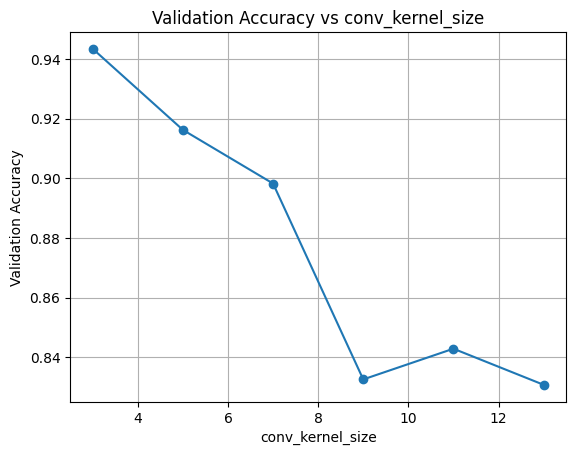

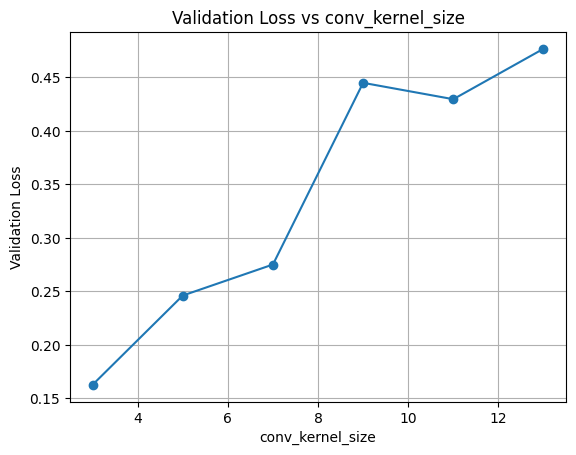

Best conv_kernel_size: 3.0

--- Running experiment for conv_dropout ---



Testing conv_dropout:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.6473, Train Acc: 76.70%, Val Loss: 0.4949, Val Acc: 81.37%
Epoch 2/10, Train Loss: 0.4030, Train Acc: 85.64%, Val Loss: 0.3257, Val Acc: 88.50%
Epoch 3/10, Train Loss: 0.3317, Train Acc: 88.35%, Val Loss: 0.3240, Val Acc: 88.15%
Epoch 4/10, Train Loss: 0.2821, Train Acc: 90.09%, Val Loss: 0.2973, Val Acc: 89.33%
Epoch 5/10, Train Loss: 0.2534, Train Acc: 91.22%, Val Loss: 0.2822, Val Acc: 90.26%
Epoch 6/10, Train Loss: 0.2270, Train Acc: 92.07%, Val Loss: 0.2461, Val Acc: 91.40%
Epoch 7/10, Train Loss: 0.2122, Train Acc: 92.65%, Val Loss: 0.2330, Val Acc: 91.98%
Epoch 8/10, Train Loss: 0.1964, Train Acc: 93.20%, Val Loss: 0.2059, Val Acc: 93.13%
Epoch 9/10, Train Loss: 0.1831, Train Acc: 93.81%, Val Loss: 0.2171, Val Acc: 92.68%



Testing conv_dropout:  17%|█▋        | 1/6 [04:43<23:37, 283.53s/it]

Epoch 10/10, Train Loss: 0.1690, Train Acc: 94.17%, Val Loss: 0.2325, Val Acc: 92.67%
Epoch 1/10, Train Loss: 0.7154, Train Acc: 74.02%, Val Loss: 0.4761, Val Acc: 83.43%
Epoch 2/10, Train Loss: 0.4689, Train Acc: 83.38%, Val Loss: 0.3960, Val Acc: 86.37%
Epoch 3/10, Train Loss: 0.3931, Train Acc: 86.05%, Val Loss: 0.3429, Val Acc: 87.75%
Epoch 4/10, Train Loss: 0.3460, Train Acc: 87.84%, Val Loss: 0.3906, Val Acc: 85.24%
Epoch 5/10, Train Loss: 0.3096, Train Acc: 89.09%, Val Loss: 0.2924, Val Acc: 89.41%
Epoch 6/10, Train Loss: 0.2876, Train Acc: 89.96%, Val Loss: 0.4041, Val Acc: 85.61%
Epoch 7/10, Train Loss: 0.2679, Train Acc: 90.57%, Val Loss: 0.2186, Val Acc: 92.03%
Epoch 8/10, Train Loss: 0.2496, Train Acc: 91.33%, Val Loss: 0.1921, Val Acc: 93.14%
Epoch 9/10, Train Loss: 0.2352, Train Acc: 91.85%, Val Loss: 0.2037, Val Acc: 92.83%



Testing conv_dropout:  33%|███▎      | 2/6 [09:27<18:55, 283.87s/it]

Epoch 10/10, Train Loss: 0.2284, Train Acc: 92.13%, Val Loss: 0.1880, Val Acc: 93.36%
Epoch 1/10, Train Loss: 0.7466, Train Acc: 72.86%, Val Loss: 0.4623, Val Acc: 82.97%
Epoch 2/10, Train Loss: 0.4975, Train Acc: 82.11%, Val Loss: 0.5113, Val Acc: 81.77%
Epoch 3/10, Train Loss: 0.4242, Train Acc: 85.03%, Val Loss: 0.4271, Val Acc: 85.21%
Epoch 4/10, Train Loss: 0.3767, Train Acc: 86.85%, Val Loss: 0.2789, Val Acc: 90.60%
Epoch 5/10, Train Loss: 0.3418, Train Acc: 87.99%, Val Loss: 0.2502, Val Acc: 91.20%
Epoch 6/10, Train Loss: 0.3166, Train Acc: 88.91%, Val Loss: 0.2448, Val Acc: 91.39%
Epoch 7/10, Train Loss: 0.2961, Train Acc: 89.80%, Val Loss: 0.2877, Val Acc: 89.37%
Epoch 8/10, Train Loss: 0.2785, Train Acc: 90.40%, Val Loss: 0.2468, Val Acc: 91.07%
Epoch 9/10, Train Loss: 0.2657, Train Acc: 90.85%, Val Loss: 0.3299, Val Acc: 88.47%



Testing conv_dropout:  50%|█████     | 3/6 [14:10<14:10, 283.49s/it]

Epoch 10/10, Train Loss: 0.2496, Train Acc: 91.30%, Val Loss: 0.2020, Val Acc: 93.01%
Epoch 1/10, Train Loss: 0.8488, Train Acc: 69.04%, Val Loss: 0.6910, Val Acc: 74.98%
Epoch 2/10, Train Loss: 0.5856, Train Acc: 79.03%, Val Loss: 0.4787, Val Acc: 82.54%
Epoch 3/10, Train Loss: 0.4912, Train Acc: 82.61%, Val Loss: 0.3625, Val Acc: 87.85%
Epoch 4/10, Train Loss: 0.4510, Train Acc: 84.21%, Val Loss: 0.4082, Val Acc: 85.26%
Epoch 5/10, Train Loss: 0.4145, Train Acc: 85.44%, Val Loss: 0.3170, Val Acc: 88.40%
Epoch 6/10, Train Loss: 0.3894, Train Acc: 86.41%, Val Loss: 0.2927, Val Acc: 89.53%
Epoch 7/10, Train Loss: 0.3624, Train Acc: 87.39%, Val Loss: 0.2776, Val Acc: 90.33%
Epoch 8/10, Train Loss: 0.3462, Train Acc: 88.01%, Val Loss: 0.2339, Val Acc: 91.83%
Epoch 9/10, Train Loss: 0.3322, Train Acc: 88.50%, Val Loss: 0.2618, Val Acc: 90.64%



Testing conv_dropout:  67%|██████▋   | 4/6 [18:54<09:27, 283.61s/it]

Epoch 10/10, Train Loss: 0.3154, Train Acc: 89.09%, Val Loss: 0.2441, Val Acc: 91.73%
Epoch 1/10, Train Loss: 0.9909, Train Acc: 62.86%, Val Loss: 0.5719, Val Acc: 80.01%
Epoch 2/10, Train Loss: 0.6906, Train Acc: 75.08%, Val Loss: 0.5533, Val Acc: 80.38%
Epoch 3/10, Train Loss: 0.6025, Train Acc: 78.46%, Val Loss: 0.5869, Val Acc: 80.85%
Epoch 4/10, Train Loss: 0.5555, Train Acc: 80.35%, Val Loss: 0.4104, Val Acc: 86.26%
Epoch 5/10, Train Loss: 0.5147, Train Acc: 81.72%, Val Loss: 0.3956, Val Acc: 85.12%
Epoch 6/10, Train Loss: 0.4904, Train Acc: 82.82%, Val Loss: 0.3339, Val Acc: 87.42%
Epoch 7/10, Train Loss: 0.4682, Train Acc: 83.69%, Val Loss: 0.3151, Val Acc: 88.59%
Epoch 8/10, Train Loss: 0.4446, Train Acc: 84.43%, Val Loss: 0.3174, Val Acc: 88.34%
Epoch 9/10, Train Loss: 0.4273, Train Acc: 85.18%, Val Loss: 0.3268, Val Acc: 87.93%



Testing conv_dropout:  83%|████████▎ | 5/6 [23:36<04:43, 283.08s/it]

Epoch 10/10, Train Loss: 0.4071, Train Acc: 85.88%, Val Loss: 0.2845, Val Acc: 90.01%
Epoch 1/10, Train Loss: 1.3644, Train Acc: 46.85%, Val Loss: 1.0457, Val Acc: 57.88%
Epoch 2/10, Train Loss: 1.1055, Train Acc: 56.86%, Val Loss: 0.9046, Val Acc: 65.12%
Epoch 3/10, Train Loss: 1.0060, Train Acc: 60.57%, Val Loss: 1.0241, Val Acc: 56.81%
Epoch 4/10, Train Loss: 0.9451, Train Acc: 63.39%, Val Loss: 0.6939, Val Acc: 70.96%
Epoch 5/10, Train Loss: 0.9027, Train Acc: 65.12%, Val Loss: 0.8853, Val Acc: 63.51%
Epoch 6/10, Train Loss: 0.8733, Train Acc: 66.34%, Val Loss: 0.5893, Val Acc: 75.83%
Epoch 7/10, Train Loss: 0.8417, Train Acc: 67.55%, Val Loss: 0.5822, Val Acc: 75.52%
Epoch 8/10, Train Loss: 0.8157, Train Acc: 68.67%, Val Loss: 0.6507, Val Acc: 73.86%
Epoch 9/10, Train Loss: 0.8006, Train Acc: 69.23%, Val Loss: 0.5846, Val Acc: 72.65%


Testing conv_dropout: 100%|██████████| 6/6 [28:18<00:00, 283.02s/it]

Epoch 10/10, Train Loss: 0.7796, Train Acc: 70.15%, Val Loss: 0.7095, Val Acc: 66.93%


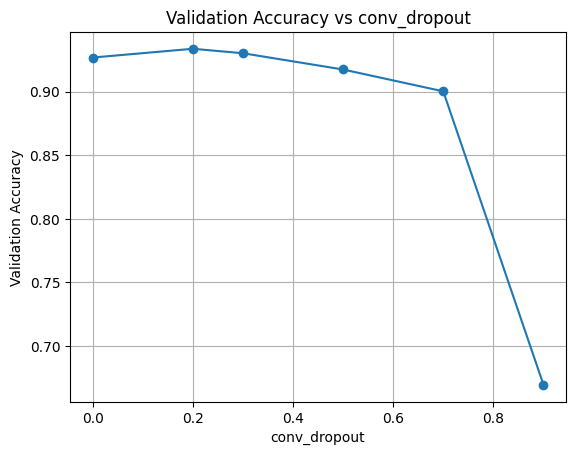

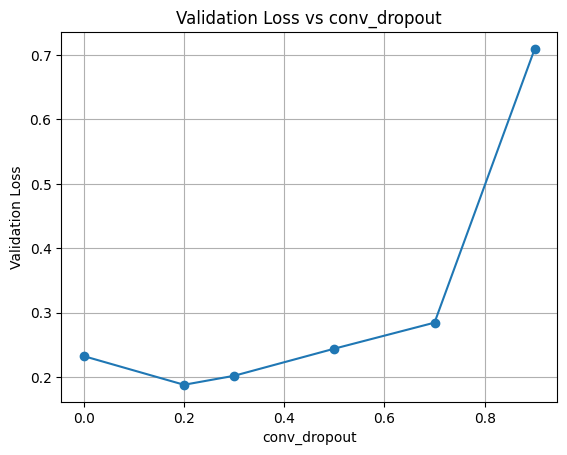

Best conv_dropout: 0.2

--- Running experiment for activation_fn ---



Testing activation_fn:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.8425, Train Acc: 69.20%, Val Loss: 0.6204, Val Acc: 76.57%
Epoch 2/10, Train Loss: 0.5707, Train Acc: 79.60%, Val Loss: 0.4733, Val Acc: 83.09%
Epoch 3/10, Train Loss: 0.4914, Train Acc: 82.42%, Val Loss: 0.6067, Val Acc: 78.40%
Epoch 4/10, Train Loss: 0.4406, Train Acc: 84.31%, Val Loss: 0.3147, Val Acc: 88.95%
Epoch 5/10, Train Loss: 0.4102, Train Acc: 85.53%, Val Loss: 0.2979, Val Acc: 89.91%
Epoch 6/10, Train Loss: 0.3835, Train Acc: 86.46%, Val Loss: 0.2950, Val Acc: 89.70%
Epoch 7/10, Train Loss: 0.3583, Train Acc: 87.35%, Val Loss: 0.2553, Val Acc: 90.87%
Epoch 8/10, Train Loss: 0.3426, Train Acc: 87.85%, Val Loss: 0.3479, Val Acc: 87.90%
Epoch 9/10, Train Loss: 0.3289, Train Acc: 88.47%, Val Loss: 0.2152, Val Acc: 92.62%



Testing activation_fn:  33%|███▎      | 1/3 [04:43<09:26, 283.40s/it]

Epoch 10/10, Train Loss: 0.3134, Train Acc: 89.03%, Val Loss: 0.2246, Val Acc: 92.19%
Epoch 1/10, Train Loss: 0.8535, Train Acc: 68.80%, Val Loss: 0.6171, Val Acc: 77.51%
Epoch 2/10, Train Loss: 0.6329, Train Acc: 77.29%, Val Loss: 0.4796, Val Acc: 82.66%
Epoch 3/10, Train Loss: 0.5476, Train Acc: 80.54%, Val Loss: 0.4125, Val Acc: 85.10%
Epoch 4/10, Train Loss: 0.4989, Train Acc: 82.28%, Val Loss: 0.4224, Val Acc: 85.34%
Epoch 5/10, Train Loss: 0.4645, Train Acc: 83.56%, Val Loss: 0.3707, Val Acc: 87.04%
Epoch 6/10, Train Loss: 0.4420, Train Acc: 84.32%, Val Loss: 0.4046, Val Acc: 86.29%
Epoch 7/10, Train Loss: 0.4226, Train Acc: 85.09%, Val Loss: 0.4092, Val Acc: 86.05%
Epoch 8/10, Train Loss: 0.4076, Train Acc: 85.60%, Val Loss: 0.3088, Val Acc: 89.04%
Epoch 9/10, Train Loss: 0.3926, Train Acc: 86.24%, Val Loss: 0.3242, Val Acc: 88.88%



Testing activation_fn:  67%|██████▋   | 2/3 [09:27<04:43, 283.65s/it]

Epoch 10/10, Train Loss: 0.3874, Train Acc: 86.43%, Val Loss: 0.2885, Val Acc: 89.91%
Epoch 1/10, Train Loss: 1.1124, Train Acc: 57.83%, Val Loss: 0.8470, Val Acc: 68.04%
Epoch 2/10, Train Loss: 0.8428, Train Acc: 68.88%, Val Loss: 0.7843, Val Acc: 71.32%
Epoch 3/10, Train Loss: 0.7344, Train Acc: 73.13%, Val Loss: 0.5499, Val Acc: 79.64%
Epoch 4/10, Train Loss: 0.6627, Train Acc: 75.81%, Val Loss: 0.5029, Val Acc: 81.50%
Epoch 5/10, Train Loss: 0.6125, Train Acc: 77.76%, Val Loss: 0.4805, Val Acc: 82.04%
Epoch 6/10, Train Loss: 0.5652, Train Acc: 79.67%, Val Loss: 0.4176, Val Acc: 84.42%
Epoch 7/10, Train Loss: 0.5342, Train Acc: 80.84%, Val Loss: 0.3858, Val Acc: 86.31%
Epoch 8/10, Train Loss: 0.5051, Train Acc: 81.88%, Val Loss: 0.3613, Val Acc: 87.22%
Epoch 9/10, Train Loss: 0.4793, Train Acc: 82.85%, Val Loss: 0.3598, Val Acc: 87.38%


Testing activation_fn: 100%|██████████| 3/3 [14:09<00:00, 283.21s/it]

Epoch 10/10, Train Loss: 0.4647, Train Acc: 83.46%, Val Loss: 0.3376, Val Acc: 88.06%


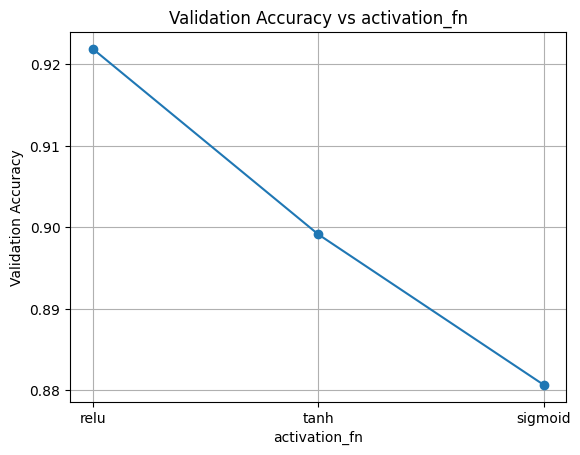

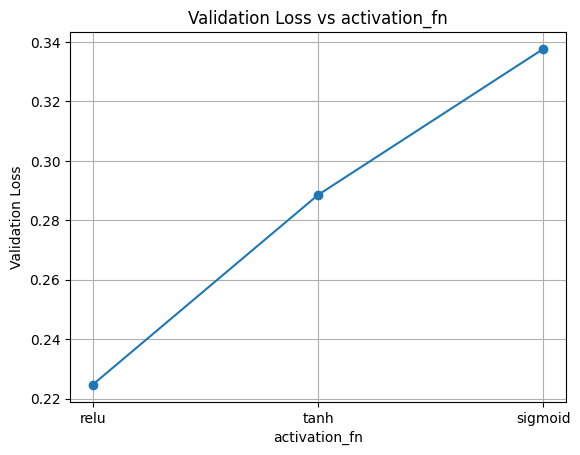

Best activation_fn: relu

--- Running experiment for batch_size ---



Testing batch_size:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.9018, Train Acc: 66.89%, Val Loss: 0.7538, Val Acc: 74.36%
Epoch 2/10, Train Loss: 0.6265, Train Acc: 77.81%, Val Loss: 0.4381, Val Acc: 84.25%
Epoch 3/10, Train Loss: 0.5317, Train Acc: 81.29%, Val Loss: 0.3861, Val Acc: 85.95%
Epoch 4/10, Train Loss: 0.4803, Train Acc: 83.13%, Val Loss: 0.3740, Val Acc: 87.19%
Epoch 5/10, Train Loss: 0.4407, Train Acc: 84.60%, Val Loss: 0.2950, Val Acc: 90.12%
Epoch 6/10, Train Loss: 0.4114, Train Acc: 85.74%, Val Loss: 0.2709, Val Acc: 90.44%
Epoch 7/10, Train Loss: 0.3870, Train Acc: 86.54%, Val Loss: 0.2547, Val Acc: 91.33%
Epoch 8/10, Train Loss: 0.3673, Train Acc: 87.21%, Val Loss: 0.2410, Val Acc: 91.37%
Epoch 9/10, Train Loss: 0.3521, Train Acc: 87.91%, Val Loss: 0.2280, Val Acc: 92.00%



Testing batch_size:  17%|█▋        | 1/6 [06:10<30:52, 370.40s/it]

Epoch 10/10, Train Loss: 0.3381, Train Acc: 88.32%, Val Loss: 0.2798, Val Acc: 89.65%
Epoch 1/10, Train Loss: 0.8411, Train Acc: 69.07%, Val Loss: 0.5206, Val Acc: 81.96%
Epoch 2/10, Train Loss: 0.5782, Train Acc: 79.35%, Val Loss: 0.4496, Val Acc: 83.81%
Epoch 3/10, Train Loss: 0.4983, Train Acc: 82.23%, Val Loss: 0.3736, Val Acc: 86.94%
Epoch 4/10, Train Loss: 0.4537, Train Acc: 84.00%, Val Loss: 0.6525, Val Acc: 77.44%
Epoch 5/10, Train Loss: 0.4242, Train Acc: 85.07%, Val Loss: 0.3017, Val Acc: 89.30%
Epoch 6/10, Train Loss: 0.3931, Train Acc: 86.13%, Val Loss: 0.2821, Val Acc: 90.19%
Epoch 7/10, Train Loss: 0.3721, Train Acc: 86.98%, Val Loss: 0.2603, Val Acc: 90.93%
Epoch 8/10, Train Loss: 0.3495, Train Acc: 87.76%, Val Loss: 0.2529, Val Acc: 91.01%
Epoch 9/10, Train Loss: 0.3343, Train Acc: 88.29%, Val Loss: 0.2325, Val Acc: 92.12%



Testing batch_size:  33%|███▎      | 2/6 [10:53<21:16, 319.18s/it]

Epoch 10/10, Train Loss: 0.3231, Train Acc: 88.81%, Val Loss: 0.2240, Val Acc: 92.28%
Epoch 1/10, Train Loss: 0.8251, Train Acc: 69.66%, Val Loss: 0.4605, Val Acc: 83.11%
Epoch 2/10, Train Loss: 0.5416, Train Acc: 80.52%, Val Loss: 0.4676, Val Acc: 83.80%
Epoch 3/10, Train Loss: 0.4588, Train Acc: 83.64%, Val Loss: 0.3434, Val Acc: 86.92%
Epoch 4/10, Train Loss: 0.4161, Train Acc: 85.15%, Val Loss: 0.3861, Val Acc: 85.79%
Epoch 5/10, Train Loss: 0.3810, Train Acc: 86.50%, Val Loss: 0.3853, Val Acc: 86.79%
Epoch 6/10, Train Loss: 0.3584, Train Acc: 87.31%, Val Loss: 0.2503, Val Acc: 91.21%
Epoch 7/10, Train Loss: 0.3379, Train Acc: 88.18%, Val Loss: 0.2408, Val Acc: 91.94%
Epoch 8/10, Train Loss: 0.3241, Train Acc: 88.76%, Val Loss: 0.2312, Val Acc: 91.98%
Epoch 9/10, Train Loss: 0.3099, Train Acc: 89.22%, Val Loss: 0.2579, Val Acc: 90.97%



Testing batch_size:  50%|█████     | 3/6 [14:55<14:11, 283.86s/it]

Epoch 10/10, Train Loss: 0.2942, Train Acc: 89.89%, Val Loss: 0.2213, Val Acc: 92.14%
Epoch 1/10, Train Loss: 0.8119, Train Acc: 70.03%, Val Loss: 0.5209, Val Acc: 81.01%
Epoch 2/10, Train Loss: 0.5259, Train Acc: 80.98%, Val Loss: 0.4690, Val Acc: 82.91%
Epoch 3/10, Train Loss: 0.4544, Train Acc: 83.63%, Val Loss: 0.4191, Val Acc: 85.66%
Epoch 4/10, Train Loss: 0.4057, Train Acc: 85.47%, Val Loss: 0.3832, Val Acc: 86.82%
Epoch 5/10, Train Loss: 0.3771, Train Acc: 86.69%, Val Loss: 0.3776, Val Acc: 86.40%
Epoch 6/10, Train Loss: 0.3531, Train Acc: 87.48%, Val Loss: 0.3741, Val Acc: 87.07%
Epoch 7/10, Train Loss: 0.3325, Train Acc: 88.33%, Val Loss: 0.4108, Val Acc: 84.55%
Epoch 8/10, Train Loss: 0.3159, Train Acc: 88.95%, Val Loss: 0.2789, Val Acc: 90.33%
Epoch 9/10, Train Loss: 0.2975, Train Acc: 89.53%, Val Loss: 0.2165, Val Acc: 92.67%



Testing batch_size:  67%|██████▋   | 4/6 [18:45<08:45, 262.50s/it]

Epoch 10/10, Train Loss: 0.2858, Train Acc: 89.91%, Val Loss: 0.3826, Val Acc: 86.17%
Epoch 1/10, Train Loss: 0.8593, Train Acc: 68.39%, Val Loss: 0.5924, Val Acc: 78.65%
Epoch 2/10, Train Loss: 0.5321, Train Acc: 80.67%, Val Loss: 0.4324, Val Acc: 84.74%
Epoch 3/10, Train Loss: 0.4453, Train Acc: 83.82%, Val Loss: 0.3756, Val Acc: 86.19%
Epoch 4/10, Train Loss: 0.3982, Train Acc: 85.75%, Val Loss: 0.3372, Val Acc: 88.01%
Epoch 5/10, Train Loss: 0.3597, Train Acc: 87.04%, Val Loss: 0.2766, Val Acc: 90.37%
Epoch 6/10, Train Loss: 0.3364, Train Acc: 88.13%, Val Loss: 0.2621, Val Acc: 90.61%
Epoch 7/10, Train Loss: 0.3218, Train Acc: 88.61%, Val Loss: 0.2964, Val Acc: 88.98%
Epoch 8/10, Train Loss: 0.3002, Train Acc: 89.35%, Val Loss: 0.3230, Val Acc: 89.09%
Epoch 9/10, Train Loss: 0.2873, Train Acc: 89.97%, Val Loss: 0.2341, Val Acc: 91.91%



Testing batch_size:  83%|████████▎ | 5/6 [22:22<04:06, 246.29s/it]

Epoch 10/10, Train Loss: 0.2749, Train Acc: 90.26%, Val Loss: 0.2720, Val Acc: 90.91%
Epoch 1/10, Train Loss: 0.9152, Train Acc: 66.30%, Val Loss: 0.5260, Val Acc: 81.34%
Epoch 2/10, Train Loss: 0.5484, Train Acc: 80.23%, Val Loss: 0.4073, Val Acc: 85.88%
Epoch 3/10, Train Loss: 0.4566, Train Acc: 83.79%, Val Loss: 0.4211, Val Acc: 85.36%
Epoch 4/10, Train Loss: 0.4064, Train Acc: 85.68%, Val Loss: 0.3957, Val Acc: 85.95%
Epoch 5/10, Train Loss: 0.3659, Train Acc: 87.05%, Val Loss: 0.3031, Val Acc: 89.98%
Epoch 6/10, Train Loss: 0.3393, Train Acc: 87.98%, Val Loss: 0.3537, Val Acc: 87.81%
Epoch 7/10, Train Loss: 0.3166, Train Acc: 88.88%, Val Loss: 0.2484, Val Acc: 91.59%
Epoch 8/10, Train Loss: 0.2998, Train Acc: 89.42%, Val Loss: 0.2787, Val Acc: 90.35%
Epoch 9/10, Train Loss: 0.2820, Train Acc: 90.18%, Val Loss: 0.2385, Val Acc: 91.51%


Testing batch_size: 100%|██████████| 6/6 [26:00<00:00, 260.14s/it]

Epoch 10/10, Train Loss: 0.2770, Train Acc: 90.21%, Val Loss: 0.2143, Val Acc: 92.76%


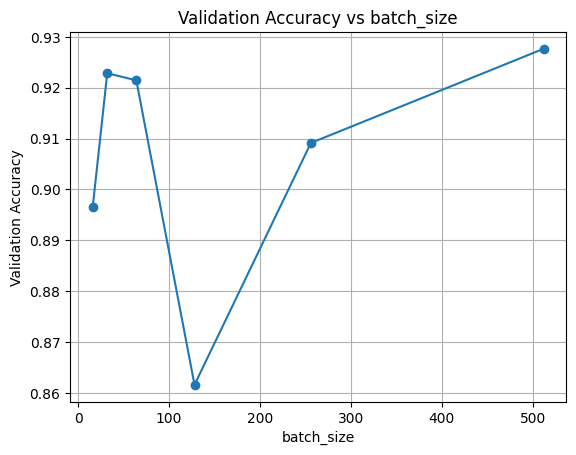

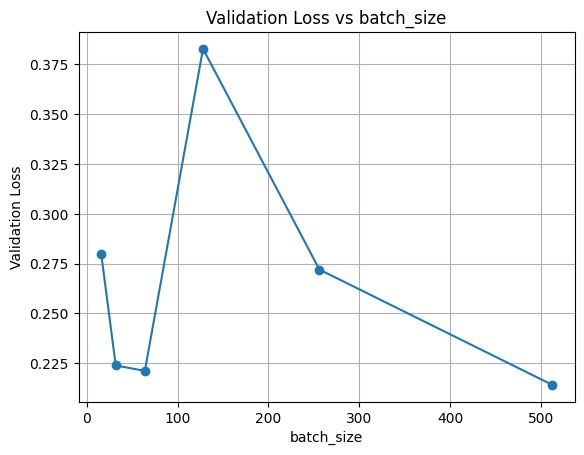

Best batch_size: 512.0

--- Running experiment for optimizer_type ---



Testing optimizer_type:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.8415, Train Acc: 69.21%, Val Loss: 0.5023, Val Acc: 82.00%
Epoch 2/10, Train Loss: 0.5672, Train Acc: 79.64%, Val Loss: 0.3838, Val Acc: 86.59%
Epoch 3/10, Train Loss: 0.4864, Train Acc: 82.57%, Val Loss: 0.4776, Val Acc: 82.42%
Epoch 4/10, Train Loss: 0.4439, Train Acc: 84.27%, Val Loss: 0.3006, Val Acc: 89.20%
Epoch 5/10, Train Loss: 0.4153, Train Acc: 85.35%, Val Loss: 0.3858, Val Acc: 86.76%
Epoch 6/10, Train Loss: 0.3889, Train Acc: 86.33%, Val Loss: 0.3775, Val Acc: 86.28%
Epoch 7/10, Train Loss: 0.3680, Train Acc: 87.15%, Val Loss: 0.2888, Val Acc: 88.83%
Epoch 8/10, Train Loss: 0.3498, Train Acc: 87.74%, Val Loss: 0.2546, Val Acc: 91.16%
Epoch 9/10, Train Loss: 0.3365, Train Acc: 88.21%, Val Loss: 0.2579, Val Acc: 90.53%



Testing optimizer_type:  33%|███▎      | 1/3 [04:45<09:31, 285.93s/it]

Epoch 10/10, Train Loss: 0.3201, Train Acc: 88.84%, Val Loss: 0.2262, Val Acc: 92.31%
Epoch 1/10, Train Loss: 1.3877, Train Acc: 49.82%, Val Loss: 0.9992, Val Acc: 63.60%
Epoch 2/10, Train Loss: 0.9907, Train Acc: 63.61%, Val Loss: 0.7464, Val Acc: 72.58%
Epoch 3/10, Train Loss: 0.8169, Train Acc: 70.64%, Val Loss: 0.7300, Val Acc: 74.66%
Epoch 4/10, Train Loss: 0.7102, Train Acc: 74.54%, Val Loss: 0.6011, Val Acc: 77.49%
Epoch 5/10, Train Loss: 0.6498, Train Acc: 76.94%, Val Loss: 0.6287, Val Acc: 77.48%
Epoch 6/10, Train Loss: 0.6009, Train Acc: 78.64%, Val Loss: 0.4763, Val Acc: 83.45%
Epoch 7/10, Train Loss: 0.5657, Train Acc: 80.00%, Val Loss: 0.4280, Val Acc: 85.57%
Epoch 8/10, Train Loss: 0.5307, Train Acc: 81.43%, Val Loss: 0.4077, Val Acc: 85.63%
Epoch 9/10, Train Loss: 0.5068, Train Acc: 82.34%, Val Loss: 0.4714, Val Acc: 84.31%



Testing optimizer_type:  67%|██████▋   | 2/3 [09:22<04:40, 280.39s/it]

Epoch 10/10, Train Loss: 0.4829, Train Acc: 83.02%, Val Loss: 0.6087, Val Acc: 78.45%
Epoch 1/10, Train Loss: 0.8622, Train Acc: 68.33%, Val Loss: 0.9803, Val Acc: 66.64%
Epoch 2/10, Train Loss: 0.5945, Train Acc: 78.81%, Val Loss: 0.6305, Val Acc: 77.23%
Epoch 3/10, Train Loss: 0.5105, Train Acc: 81.91%, Val Loss: 0.3585, Val Acc: 87.56%
Epoch 4/10, Train Loss: 0.4567, Train Acc: 83.91%, Val Loss: 0.4544, Val Acc: 84.62%
Epoch 5/10, Train Loss: 0.4271, Train Acc: 85.05%, Val Loss: 0.3423, Val Acc: 87.99%
Epoch 6/10, Train Loss: 0.3943, Train Acc: 86.24%, Val Loss: 0.6608, Val Acc: 80.23%
Epoch 7/10, Train Loss: 0.3778, Train Acc: 86.84%, Val Loss: 0.5794, Val Acc: 78.48%
Epoch 8/10, Train Loss: 0.3564, Train Acc: 87.85%, Val Loss: 0.4475, Val Acc: 85.22%
Epoch 9/10, Train Loss: 0.3401, Train Acc: 88.38%, Val Loss: 0.7648, Val Acc: 75.05%


Testing optimizer_type: 100%|██████████| 3/3 [14:03<00:00, 281.10s/it]

Epoch 10/10, Train Loss: 0.3240, Train Acc: 88.86%, Val Loss: 1.3166, Val Acc: 66.85%


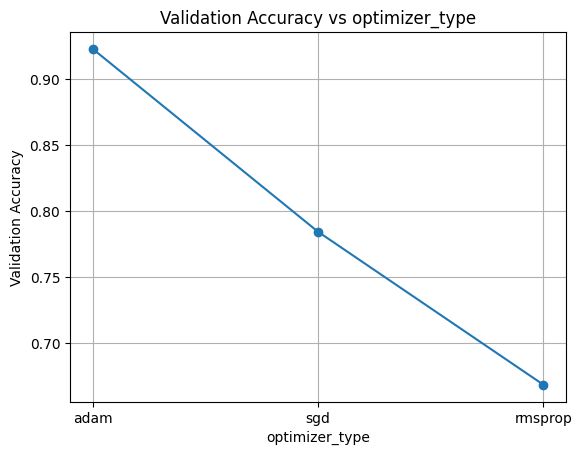

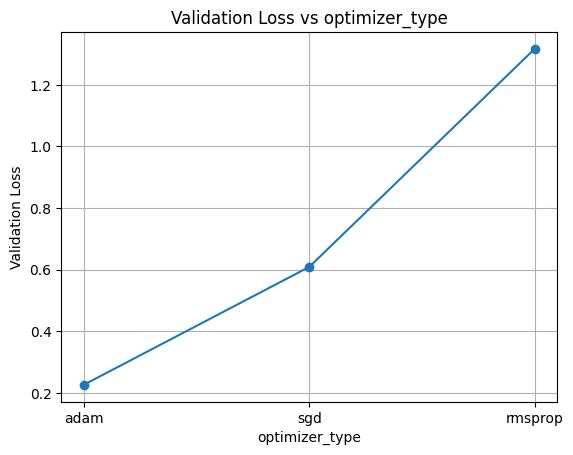

Best optimizer_type: adam
Best values selected:
• conv_kernel_size: 3.0
• conv_dropout: 0.2
• activation_fn: relu
• batch_size: 512.0
• optimizer_type: adam
• num_conv_layers: 2
• fc_hidden_units: 64
• pool_kernel_size: 5
• pool_stride: 1
• fc_dropout: 0
• num_epochs: 20


In [10]:

# RUN ALL EXPERIMENTS
print("Starting all experiments...")
best_params, all_results = run_all_experiments()

#from previous run
best_params['num_conv_layers'] = 2
best_params['fc_hidden_units'] = 64
best_params['pool_kernel_size'] = 5
best_params['pool_stride'] = 1
best_params['fc_dropout'] = 0
best_params['num_epochs'] = 20

print("Best values selected:")
for param, value in best_params.items():
    print(f"• {param}: {value}")


In [11]:

# TRAIN FINAL MODEL AND EVALUATE ON TEST SET
print("\nTraining and evaluating the final model...")
y_true, y_pred = train_final_model(best_params)
print("Final model evaluation complete.")


Training and evaluating the final model...
Training final model...
Epoch 1/20, Train Loss: 0.9028, Train Acc: 68.66%, Val Loss: 0.6300, Val Acc: 76.75%
Epoch 2/20, Train Loss: 0.4583, Train Acc: 83.52%, Val Loss: 0.5355, Val Acc: 79.99%
Epoch 3/20, Train Loss: 0.3377, Train Acc: 88.30%, Val Loss: 0.4132, Val Acc: 85.59%
Epoch 4/20, Train Loss: 0.2703, Train Acc: 90.65%, Val Loss: 0.3066, Val Acc: 88.75%
Epoch 5/20, Train Loss: 0.2334, Train Acc: 91.92%, Val Loss: 0.2738, Val Acc: 90.49%
Epoch 6/20, Train Loss: 0.2030, Train Acc: 93.00%, Val Loss: 0.2044, Val Acc: 93.08%
Epoch 7/20, Train Loss: 0.1815, Train Acc: 93.76%, Val Loss: 0.2228, Val Acc: 91.89%
Epoch 8/20, Train Loss: 0.1664, Train Acc: 94.18%, Val Loss: 0.1685, Val Acc: 94.53%
Epoch 9/20, Train Loss: 0.1474, Train Acc: 94.91%, Val Loss: 0.1491, Val Acc: 95.03%
Epoch 10/20, Train Loss: 0.1394, Train Acc: 95.21%, Val Loss: 0.1375, Val Acc: 95.21%
Epoch 11/20, Train Loss: 0.1294, Train Acc: 95.52%, Val Loss: 0.1241, Val Acc: 95


✅ Test Accuracy: 86.78%


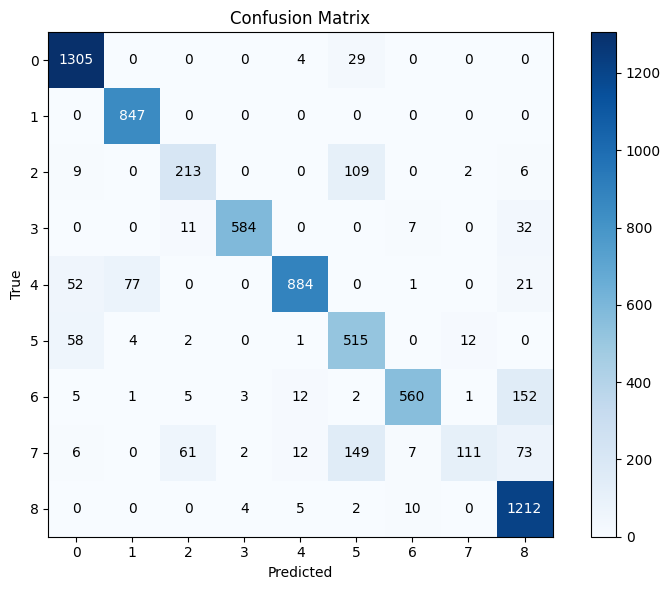

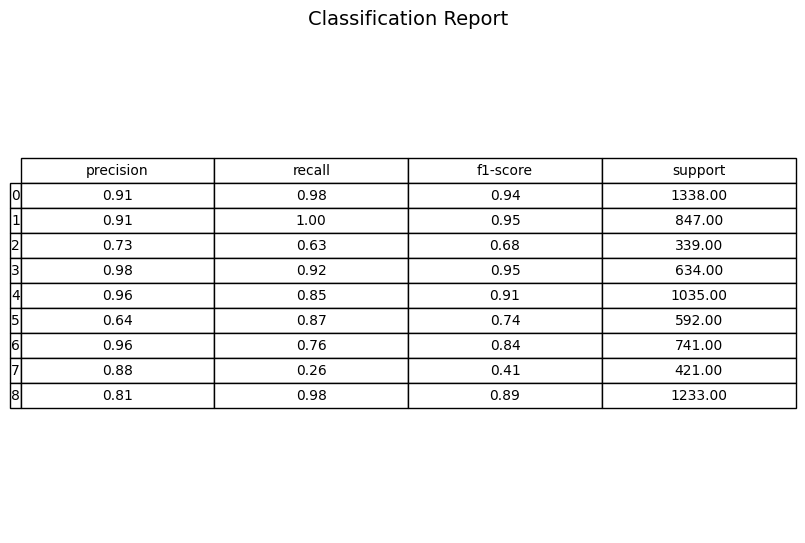

In [12]:
from sklearn.metrics import classification_report
# Print Test Accuracy
test_accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")

# Plot Confusion Matrix (matplotlib only)

num_classes = 9
cm = torch.zeros(num_classes, num_classes, dtype=torch.int32)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers to each square
thresh = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, int(cm[i, j]),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


#Visual Classification Report Table (matplotlib only)

report = classification_report(y_true, y_pred, digits=2, output_dict=True)
labels = list(report.keys())[:-3]  # exclude avg/total
metrics = ['precision', 'recall', 'f1-score', 'support']

data = [[report[label][metric] for metric in metrics] for label in labels]

fig, ax = plt.subplots(figsize=(10, 0.5 * len(labels) + 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(
      cellText=[[f"{val:.2f}" if isinstance(val, float) else int(val) for val in row] for row in data],
      rowLabels=labels,
      colLabels=metrics,
      cellLoc='center',
      loc='center'
    )
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Classification Report", fontsize=14)
plt.show()

## **References**

* **CMPE452 Course Notes**  
Used throughout the assignment as the primary source for CNN model architecture, training procedures and the methodology for conducting controlled hyperparameter experiments.

* **OpenAI ChatGPT (GPT-4, April 2024 version)**  
Used for clarifying deep learning concepts.  
Also helped debug shape mismatch errors related to feature map dimensions after convolution and pooling layers.

* **Google Gemini**  
Supported debugging during unexpected GPU crashes and out-of-memory errors.  
Used to generate final visualizations such as classification reports and confusion matrices.

* **PyTorch Documentation**  
Referenced to implement custom neural network layers, training loops, loss functions, and optimizer configurations.  
[https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
